In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame

from saturation.utils import *

In [ ]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

In [ ]:
base_path = "/data/saturation/thesis_run_20240130"
configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    F.col("n_craters_added_in_study_region").alias("ntot"),
    F.col("n_craters_in_study_region").alias("nobs"),
    F.col("center_to_center_nearest_neighbor_distance_mean").alias("mnnd"),
    "z",
    "za",
    "radius_mean",
    F.col("areal_density").alias("ad"),
    F.log10("center_to_center_nearest_neighbor_distance_mean").alias("log_mnnd"),
    F.log10(F.col("n_craters_in_study_region")).alias("log_nobs"),
    F.log10("n_craters_added_in_study_region").alias("log_ntot"),
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [ ]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config_*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

In [ ]:
# Choosing simulation 1693
simulation_id = 1693
configs_pdf[configs_pdf.simulation_id == simulation_id]

In [ ]:
# target_ntots = [300, 500, 2000, 5000, 10000, 30000, 50000, 140000]
n = (75000 - 500) // 500 + 1
target_ntots = np.linspace(500, 75000, n)
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet").cache()
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet").cache()
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet").cache()

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [ ]:
states_included = {
    1000,
    10000,
    50000,
    75000
}

s = {k: v for k, v in states.items() if k in states_included}
fig = plot_csfds_for_multiple_ntot(s, reference_slope=2.51, reference_intercept=2e5)
# fig.savefig("figures/high_destruction_csfds.png", bbox_inches="tight")
plt.show()

In [ ]:
state = states[500]
radii = state.radius.sort_values()

### 1. Construct the Likelihood Function
The likelihood function for a two-sloped Pareto distribution can be split into two parts, before and after the breakpoint $x_c$:

$
L(\alpha_1, \alpha_2, x_c; x_1, x_2, \ldots, x_n) = \prod_{x_i \leq x_c} \frac{\alpha_1 x_{\text{min}}^{\alpha_1} x_i^{-\alpha_1-1}}{1 - \left( \frac{x_{\text{min}}}{x_c} \right)^{\alpha_1}} \times \prod_{x_i > x_c} \frac{\alpha_2 x_c^{\alpha_2} x_i^{-\alpha_2-1}}{1 - \left( \frac{x_c}{x_{\text{max}}} \right)^{\alpha_2}}
$

### 2. Construct the Log-Likelihood Function
Taking the natural logarithm of the likelihood function:

$
\log L(\alpha_1, \alpha_2, x_c) = \sum_{x_i \leq x_c} \left( \log \alpha_1 + \alpha_1 \log x_{\text{min}} - (\alpha_1 + 1) \log x_i - \log \left( 1 - \left( \frac{x_{\text{min}}}{x_c} \right)^{\alpha_1} \right) \right) 
+ \sum_{x_i > x_c} \left( \log \alpha_2 + \alpha_2 \log x_c - (\alpha_2 + 1) \log x_i - \log \left( 1 - \left( \frac{x_c}{x_{\text{max}}} \right)^{\alpha_2} \right) \right)
$

### 3. Minimize the negative Log-Likelihood Function
Numerically maximize the log-likelihood function to find the estimates for $\alpha_1$, $\alpha_2$, and $x_c$. This can be done using optimization techniques.

## Trying to build a confidence region in 3d for 3 parameters

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from saturation.distributions import ParetoProbabilityDistribution


slope = 2
slope2 = slope 
n_trials = 1000
breakpoint_percentile = 0.75

d1 = ParetoProbabilityDistribution(alpha=slope, x_min=5, x_max=1000)
breakpoint = d1.pullback(breakpoint_percentile)
print(breakpoint)

d2 = ParetoProbabilityDistribution(alpha=slope2, x_min=breakpoint, x_max=1000)

u1 = np.random.random(n_trials)
u2 = np.random.random(n_trials)

x_values = np.sort(
    np.array(
        [
            d1.pullback(x1) if x1 < breakpoint_percentile else d2.pullback(x2)
            for x1, x2 in zip(u1, u2)
        ]
    )
)
y = np.array(range(len(x_values) + 1, 1, -1))

6.597539553852101


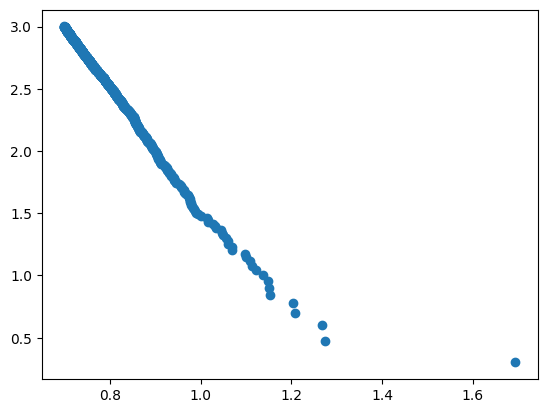

In [38]:
plt.scatter(np.log10(x_values), np.log10(y))

In [41]:
calculate_single_sloped_mle(single_sloped_test_alphas, len(x_values), np.sum(np.log(x_values)), 5, 1000)

(4.985, 1209.8289250843359)

In [33]:
bounds_alpha = (0.5, 7.0)
bounds_xc = (x_values.min(), x_values.max())
alpha_steps = 101
alpha_delta = (bounds_alpha[1] - bounds_alpha[0]) / (alpha_steps - 1)

x_values = np.sort(x_values)
breakpoint_step = 16
breakpoints = x_values[np.array(range(len(x_values) // breakpoint_step)) * breakpoint_step]
breakpoints = (breakpoints[:-1] + breakpoints[1:]) / 2

data = [
    [bounds_alpha[0] + alpha_delta * a1_step, bounds_alpha[0] + alpha_delta * a2_step, xc]
    for a1_step in range(alpha_steps)
    for a2_step in range(alpha_steps)
    for xc in breakpoints
]

two_sloped_test_parameters_df = pd.DataFrame(data, columns=["alpha1", "alpha2", "xc"])

single_sloped_test_alphas = np.array([bounds_alpha[0] + alpha_delta * x for x in range(alpha_steps)])

In [20]:
n_trials = 100000
results = []

In [21]:
from multiprocessing import Pool
from numba import njit, jit

n_workers = 28
# x_max = 1000
report_cadence = 500
two_sloped_test_parameters = two_sloped_test_parameters_df[["alpha1", "alpha2", "xc"]].values

@njit(fastmath=True, nogil=True)
def calculate_two_sloped_log_likelihood(alpha1: float,
                                        alpha2: float,
                                        x_c: float,
                                        log_x_sorted: np.array,
                                        sum_log_x: float,
                                        x_min: float,
                                        x_max: float):
    if not (x_min < x_c < x_max):
        return np.inf  # Return a large number if x_c is out of bounds

    partition_index = np.searchsorted(log_x_sorted, np.log(x_c))
    n1 = partition_index
    sum_log_part1 = np.sum(log_x_sorted[:partition_index])
    min_max_ratio1 = x_min / x_c
    
    n2 = len(log_x_sorted) - partition_index
    sum_log_part2 = sum_log_x - sum_log_part1
    min_max_ratio2 = x_c / x_max

    logL1 = (
        n1 * np.log(alpha1)
        + n1 * alpha1 * np.log(x_min)
        - (alpha1 + 1) * sum_log_part1
        - n1 * np.log(1 - min_max_ratio1 ** alpha1)
    )
    
    logL2 = (
        n2 * np.log(alpha2)
        + n2 * alpha2 * np.log(x_c)
        - (alpha2 + 1) * sum_log_part2
        - n2 * np.log(1 - min_max_ratio2 ** alpha2)
    )

    return -(logL1 + logL2)  # Negative log-likelihood for minimization


@njit(fastmath=True, nogil=True)
def calculate_single_sloped_log_likelihood(alpha:float,
                                           len_x: int,
                                           sum_log_x: float,
                                           x_min: float,
                                           x_max: float):
    ll = (
        len_x * np.log(alpha)
        + len_x * alpha * np.log(x_min)
        - (alpha + 1) * sum_log_x
        - len_x * np.log(1 - (x_min / x_max) ** alpha)
    )

    return -ll  # Negative log-likelihood for minimization

@njit(fastmath=True, nogil=True)
def calculate_single_sloped_mle(test_alphas: np.array,
                                len_x: int,
                                sum_log_x: float,
                                x_min: float,
                                x_max: float):
    ll = np.array([
        calculate_single_sloped_log_likelihood(alpha, len_x, sum_log_x, x_min, x_max)
        for alpha in test_alphas
    ])
    
    idx = np.argmin(ll)
    res = test_alphas[idx]
    return res, ll[idx]


@njit(fastmath=True, nogil=True)
def calculate_two_sloped_mle(test_parameters: np.array,
                             log_x_sorted: np.array,
                             sum_log_x: float,
                             x_min: float,
                             x_max: float):
    ll = np.array([
        calculate_two_sloped_log_likelihood(alpha1,
                                            alpha2,
                                            x_c,
                                            log_x_sorted,
                                            sum_log_x,
                                            x_min,
                                            x_max)
        for alpha1, alpha2, x_c in test_parameters
    ])
    
    idx = np.argmin(ll)
    alpha1, alpha2, x_c = test_parameters[idx]

    # Calculate sigma
    partition_index = np.searchsorted(log_x_sorted, np.log(x_c))
    n1 = partition_index
    n2 = len(log_x_sorted) - partition_index

    min_max_ratio1 = x_min / min_params[2]
    sigma1 = min_max_ratio1**alpha1 * np.log(min_max_ratio1)**2 / (1 - min_max_ratio1**alpha1)**2
    sigma1 = np.sqrt(1 / (1 / alpha1**2 - sigma1) / n1)

    min_max_ratio2 = min_params[2] / x_max
    sigma2 = min_max_ratio2**alpha1 * np.log(min_max_ratio2)**2 / (1 - min_max_ratio2**alpha2)**2
    sigma2 = np.sqrt(1 / (1 / alpha2**2 - sigma2) / n2)
    
    return alpha1, alpha2, x_c, sigma1, sigma2, ll[idx]


@njit(fastmath=True, nogil=True)
def f(_) -> list[float]:
    log_x_s = np.log(np.sort(np.random.choice(x_values, x_values.shape, replace=True)))
    sum_log_x_s = np.sum(log_x_s)
    
    x_min = np.exp(log_x_s[0])
    x_max = np.exp(log_x_s[-1])
    alpha1, alpha2, x_c, sigma1, sigma2, two_sloped_log_likelihood = calculate_two_sloped_mle(two_sloped_test_parameters, log_x_s, sum_log_x_s, x_min, x_max)
    single_sloped_alpha, single_sloped_log_likelihood = calculate_single_sloped_mle(single_sloped_test_alphas, len(log_x_s), sum_log_x_s, x_min, x_max)

    alpha1, alpha2, x_c = two_sloped_parameters
    return alpha1, alpha2, x_c, sigma1, sigma2, two_sloped_log_likelihood, single_sloped_alpha, single_sloped_log_likelihood
        

with Pool(n_workers) as pool:
    for row in pool.imap_unordered(f, range(n_trials)):
        results.append(row)
        
        if len(results) % report_cadence == 0:
            print("-----")
            print(len(results))
            res = pd.DataFrame(results, columns=["alpha1", "alpha2", "x_c", "two_sloped_neg_ll", "alpha", "single_sloped_neg_ll"])

            q025 = res.quantile(0.025)
            q975 = res.quantile(0.975)

            print(f"alpha1 CI: {q025['alpha1']:.2f}, {q975['alpha1']:.2f}")
            print(f"alpha2 CI: {q025['alpha2']:.2f}, {q975['alpha2']:.2f}")
            print(f"x_c CI: {q025['x_c']:.2f}, {q975['x_c']:.2f}")
            print(f"alpha CI: {q025['alpha']:.2f}, {q975['alpha']:.2f}")
            print(f"2-sloped negative log likelihood CI: {q025['two_sloped_neg_ll']:.2f}, {q975['two_sloped_neg_ll']:.2f}")
            print(f"1-sloped negative log likelihood CI: {q025['single_sloped_neg_ll']:.2f}, {q975['single_sloped_neg_ll']:.2f}")

-----
500
alpha1 CI: 0.96, 3.10
alpha2 CI: 2.12, 2.52
x_c CI: 6.78, 7.20
alpha CI: 2.06, 2.32
2-sloped negative log likelihood CI: 1477.44, 1642.02
1-sloped negative log likelihood CI: 2171.77, 2340.14
-----
1000
alpha1 CI: 0.96, 3.04
alpha2 CI: 2.12, 2.52
x_c CI: 6.78, 7.20
alpha CI: 2.06, 2.32
2-sloped negative log likelihood CI: 1477.15, 1645.50
1-sloped negative log likelihood CI: 2171.51, 2341.66
-----
1500
alpha1 CI: 0.92, 3.04
alpha2 CI: 2.12, 2.52
x_c CI: 6.78, 7.20
alpha CI: 2.06, 2.32
2-sloped negative log likelihood CI: 1477.92, 1645.55
1-sloped negative log likelihood CI: 2172.59, 2341.94
-----
2000
alpha1 CI: 0.96, 3.04
alpha2 CI: 2.12, 2.52
x_c CI: 6.78, 7.20
alpha CI: 2.06, 2.32
2-sloped negative log likelihood CI: 1477.37, 1644.34
1-sloped negative log likelihood CI: 2171.75, 2341.65


Process ForkPoolWorker-55:
Process ForkPoolWorker-47:
Process ForkPoolWorker-54:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-52:
Process ForkPoolWorker-59:
Process ForkPoolWorker-39:
Process ForkPoolWorker-40:
Process ForkPoolWorker-42:
Process ForkPoolWorker-46:
Process ForkPoolWorker-51:
Process ForkPoolWorker-36:
Process ForkPoolWorker-38:
Process ForkPoolWorker-58:
Process ForkPoolWorker-43:
Process ForkPoolWorker-34:
Process ForkPoolWorker-48:
Process ForkPoolWorker-44:
Process ForkPoolWorker-53:
Process ForkPoolWorker-35:
Process ForkPoolWorker-37:
Process ForkPoolWorker-57:
Process ForkPoolWorker-33:
Process ForkPoolWorker-45:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback 

KeyboardInterrupt: 

In [22]:
result_df = pd.DataFrame(results, columns=["alpha1", "alpha2", "x_c", "two_sloped_neg_ll", "alpha", "single_sloped_neg_ll"])

In [27]:
alpha_difference = result_df.alpha1 - result_df.alpha2
print(f"95% CI on alpha1 - alpha2: {alpha_difference.quantile(0.05):.3f}, {alpha_difference.quantile(0.95):.3f}")

95% CI on alpha1 - alpha2: -1.170, 0.585


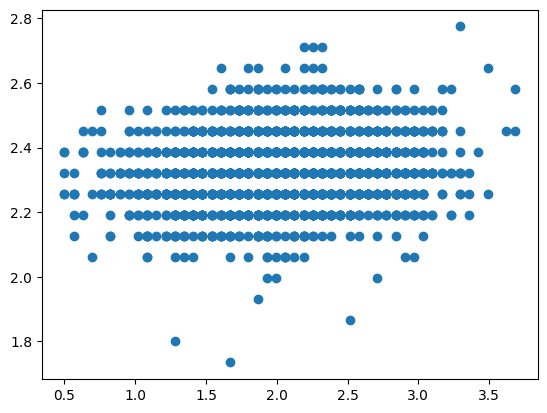

In [24]:
plt.scatter(result_df.alpha1, result_df.alpha2)

(array([ 18.,  58., 174., 317., 442., 421., 358., 202.,  85.,  15.]),
 array([-1.885, -1.573, -1.261, -0.949, -0.637, -0.325, -0.013,  0.299,
         0.611,  0.923,  1.235]),
 <BarContainer object of 10 artists>)

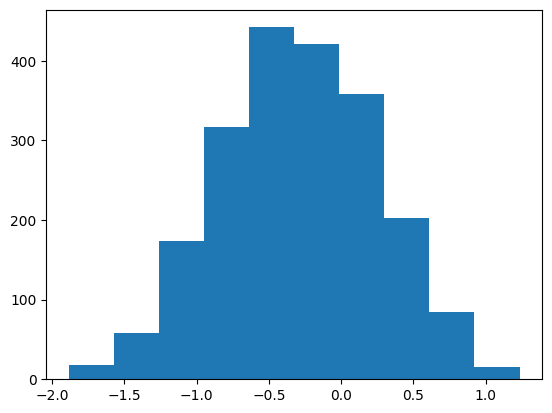

In [25]:
plt.hist(alpha_difference)

In [26]:
print(f"95% CI on alpha: {result_df.alpha.quantile(0.025):.3f}, {result_df.alpha.quantile(0.975):.3f}")

95% CI on alpha1 - alpha2: 2.060, 2.320


In [ ]:
result_df = pd.DataFrame(results, columns=["alpha1", "alpha2", "x_c", "two_sloped_neg_ll", "alpha", "single_sloped_neg_ll"])

In [ ]:
plt.scatter(
    result_df.alpha1,
    result_df.x_c,
)
plt.xlabel("alpha1")
plt.ylabel("x_c")
plt.show()

plt.scatter(
    result_df.alpha2,
    result_df.x_c,
)
plt.xlabel("alpha2")
plt.ylabel("x_c")
plt.show()

plt.scatter(
    result_df.alpha1,
    result_df.alpha2,
)
plt.xlabel("alpha1")
plt.ylabel("alpha2")
plt.show()

In [ ]:
import numpy as np
from scipy.stats import chi2
import plotly.graph_objects as go

def confidence_ellipsoid(data, confidence_level=0.95):
    # Number of observations (n) and dimensions (p)
    n, p = data.shape
    
    # Step 1: Calculate the mean vector
    mean_vector = np.mean(data, axis=0)
    
    # Step 2: Calculate the covariance matrix
    covariance_matrix = np.cov(data, rowvar=False)
    
    # Step 3: Determine the critical value
    critical_value = chi2.ppf(confidence_level, p)
    
    # Step 4: Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Step 5: Calculate the lengths of the semi-axes
    semi_axes_lengths = np.sqrt(eigenvalues * critical_value)
    
    # Step 6: Construct the ellipsoid
    ellipsoid = (mean_vector, eigenvectors, semi_axes_lengths)
    
    return ellipsoid

# Example usage with 3D data
data = result_df.values
ellipsoid = confidence_ellipsoid(data)

# Plotting the ellipsoid using Plotly
mean_vector, eigenvectors, semi_axes_lengths = ellipsoid

# Create the ellipsoid
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = semi_axes_lengths[0] * np.outer(np.cos(u), np.sin(v))
y = semi_axes_lengths[1] * np.outer(np.sin(u), np.sin(v))
z = semi_axes_lengths[2] * np.outer(np.ones_like(u), np.cos(v))

# Rotate and translate the ellipsoid
for i in range(len(x)):
    for j in range(len(x)):
        [x[i, j], y[i, j], z[i, j]] = np.dot(eigenvectors, [x[i, j], y[i, j], z[i, j]]) + mean_vector

# Plotly scatter plot for data points
scatter = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', marker=dict(size=3))

# Plotly mesh plot for the ellipsoid
ellipsoid_mesh = go.Surface(x=x, y=y, z=z, opacity=0.3, colorscale='Blues', showscale=False)

# Create the figure
fig = go.Figure(data=[scatter, ellipsoid_mesh])

# Set the layout
fig.update_layout(scene=dict(
    xaxis_title='alpha1',
    yaxis_title='alpha2',
    zaxis_title='changepoint',
))

fig.update_layout(width=1000, height=500)

# Show the plot
fig.show()

In [ ]:
"""
H0: alpha1 | x_c == alpha2 | x_c == 2
HA: ! H0

Check Bonferroni correction, similar idea
"""

## MLE through grid search

In [ ]:
slope = 2
n_trials = 1000
breakpoint_percentile = 0.75

d1 = ParetoProbabilityDistribution(alpha=slope, x_min=5, x_max=1000)
breakpoint = d1.pullback(breakpoint_percentile)
print(f"Breakpoint = {breakpoint}")

d2 = ParetoProbabilityDistribution(alpha=slope + 2, x_min=breakpoint, x_max=1000)

u1 = np.random.random(n_trials)
u2 = np.random.random(n_trials)

x = np.array(
        [
            d1.pullback(x1) if x1 < breakpoint_percentile else d2.pullback(x2)
            for x1, x2 in zip(u1, u2)
        ]
)
x = np.sort(x)

In [ ]:
plt.scatter(np.log10(x), np.log10(range(n_trials + 1, 1, -1)))

In [ ]:
bounds_alpha = (1.0, 6.0)
bounds_xc = (x.min(), x.max())
alpha_steps = 51
alpha_delta = (bounds_alpha[1] - bounds_alpha[0]) / (alpha_steps - 1)

x = np.sort(x)
breakpoint_step = 4
breakpoints = x[np.array(range(len(x) // breakpoint_step)) * breakpoint_step]
breakpoints = (breakpoints[:-1] + breakpoints[1:]) / 2

data = [
    [bounds_alpha[0] + alpha_delta * a1_step, bounds_alpha[0] + alpha_delta * a2_step, xc]
    for a1_step in range(alpha_steps)
    for a2_step in range(alpha_steps)
    for xc in breakpoints
    # for xc in np.linspace(bounds_xc[0], bounds_xc[1], xc_steps)
]

df = pd.DataFrame(data, columns=["alpha1", "alpha2", "xc"])

In [ ]:
df

In [ ]:
def create_likelihood_function(data: np.array, x_min: float, x_max: float):
    def log_likelihood(params):
        alpha_1, alpha_2, x_c = params
        if not (x_min < x_c < x_max):
            return np.inf  # Return a large number if x_c is out of bounds

        partition_index = np.searchsorted(x, x_c)
        part1 = data[:partition_index]
        part2 = data[partition_index:]
    
        logL1 = len(part1) * np.log(alpha_1) + len(part1) * alpha_1 * np.log(x_min) \
                - (alpha_1 + 1) * np.sum(np.log(part1)) \
                - len(part1) * np.log(1 - (x_min / x_c) ** alpha_1)
        
        logL2 = len(part2) * np.log(alpha_2) + len(part2) * alpha_2 * np.log(x_c) \
                - (alpha_2 + 1) * np.sum(np.log(part2)) \
                - len(part2) * np.log(1 - (x_c / x_max) ** alpha_2)

        return -(logL1 + logL2)  # Negative log-likelihood for minimization

    return log_likelihood

In [ ]:
n_trials = 10000000

results = []

In [ ]:
from multiprocessing import Pool

n_workers = 28

def f(_) -> list[float]:
    x_s = np.sort(np.random.choice(x, x.shape, replace=True))
    ll = df[["alpha1", "alpha2", "xc"]].apply(create_likelihood_function(x_s, x_s.min(), x_s.max()), axis=1)
    return list(df.iloc[np.argmin(ll)])
        

with Pool(n_workers) as pool:
    for row in pool.imap_unordered(f, range(n_trials)):
        results.append(row)
        
        if len(results) % 1000 == 0:
            print("-----")
            print(len(results))
            res = pd.DataFrame(results, columns=["a1", "a2", "x_c"])
            print(res.quantile(0.025))
            print(res.quantile(0.5))
            print(res.mean())
            print(res.quantile(0.975))

In [ ]:
# for idx in range(n_trials):
#     x_s = np.sort(np.random.choice(x, x.shape, replace=True))
#     ll = df[["alpha1", "alpha2", "xc"]].apply(create_likelihood_function(x_s, x_s.min(), x_s.max()), axis=1)
#     results.append(list(df.iloc[np.argmin(ll)]))
#     if idx % 500 == 0:
#         print(idx)

In [ ]:
res = pd.DataFrame(results, columns=["a1", "a2", "x_c"])
plt.hist(res.a1)
plt.show()
plt.hist(res.a2)
plt.show()
plt.hist(res.x_c)
plt.show()

In [ ]:
print(res.quantile(0.025))
print(res.quantile(0.5))
print(res.mean())
print(res.quantile(0.975))

In [ ]:
piecewise_regression.davies_test(x, y)

In [ ]:
pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=1)
pw_fit.summary()

In [ ]:
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)

# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4) 
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()